# Breakhis-400x Dataset

In [13]:
print("Welcome")

Welcome


# Evaluation Function

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    mean_absolute_error, 
    mean_squared_error,
    confusion_matrix
)

# Function to evaluate the model and print metrics
def evaluate_model(model_name, model, test_generator):
    # Reset the generator to start from the beginning
    test_generator.reset()  
    
    # Get predictions
    y_pred_prob = model.predict(test_generator)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Use argmax for multi-class predictions
    y_true = test_generator.classes  # True labels

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # Multi-class ROC AUC

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"AUC Score: {auc:.4f}\n")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'Confusion_{model_name}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()

# Final DNBCD Model (Custom CNN + DenseNet + Transfer Learning)

In [15]:
import os 
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Binary classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
history_fine = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 732ms/step - accuracy: 0.5234 - loss: 1.3550 - val_accuracy: 0.7025 - val_loss: 0.5572
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.6844 - loss: 0.7125 - val_accuracy: 0.7532 - val_loss: 0.4666
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.7351 - loss: 0.5601 - val_accuracy: 0.8038 - val_loss: 0.4139
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.7558 - loss: 0.5578 - val_accuracy: 0.6962 - val_loss: 0.5047
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.7465 - loss: 0.5416 - val_accuracy: 0.8608 - val_loss: 0.4132
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.7687 - loss: 0.5130 - val_accuracy: 0.7975 - val_loss: 0.4404
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.7720 - loss: 0.4948 - val_accuracy: 0.7975 - val_loss: 0.4321
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.7760 - loss: 0.4689 - val_accuracy: 0.8228 - val

In [16]:
model.save("DNBCD_Model.h5")

In [17]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 22,717,771 (86.66 MB)

 Trainable params: 7,544,707 (28.78 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 15,089,416 (57.56 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 815ms/step
Model: DNBCD
Accuracy: 0.8987
Precision: 0.9111
Recall: 0.8987
F1 Score: 0.9000
Mean Absolute Error: 0.1392
Root Mean Square Error: 0.4639
AUC Score: 0.9775



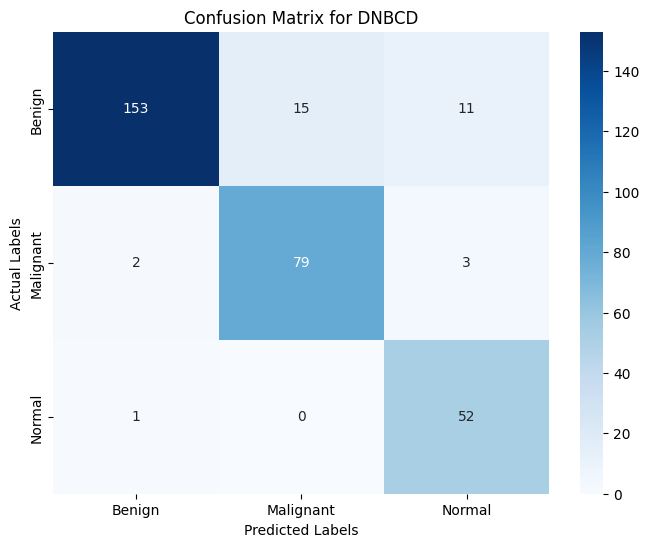

In [18]:
model_name= "DNBCD"
evaluate_model(model_name,model, test_generator)

# Mobilenet+transfer

In [19]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained MobileNet model + higher-level layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Binary classification

# Create the complete model
mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
mobilenet_history_initial = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
mobilenet_history_fine = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = mobilenet_model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.5720 - loss: 1.2283 - val_accuracy: 0.7595 - val_loss: 0.5111
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.6978 - loss: 0.6748 - val_accuracy: 0.7848 - val_loss: 0.4306
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7471 - loss: 0.5710 - val_accuracy: 0.8228 - val_loss: 0.4019
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.7674 - loss: 0.5568 - val_accuracy: 0.7975 - val_loss: 0.4582
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.7565 - loss: 0.5686 - val_accuracy: 0.8544 - val_loss: 0.3313
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.7879 - loss: 0.4869 - val_accuracy: 0.8228 - val_loss: 0.3552
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.8005 - loss: 0.4337 - val_accuracy: 0.8228 - val_loss: 0.3952
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8199 - loss: 0.4365 - val_accuracy: 0.8734 - val

In [20]:
mobilenet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 11,415,371 (43.55 MB)

 Trainable params: 3,797,827 (14.49 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 7,595,656 (28.98 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step
Model: T_Mobilenet
Accuracy: 0.8671
Precision: 0.8787
Recall: 0.8671
F1 Score: 0.8685
Mean Absolute Error: 0.1772
Root Mean Square Error: 0.5156
AUC Score: 0.9713



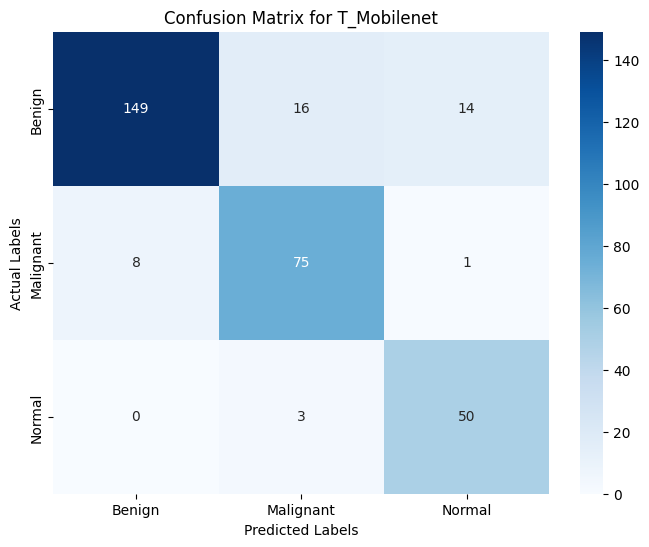

In [21]:
model_name= "T_Mobilenet"
evaluate_model(model_name,mobilenet_model, test_generator)

# Resnet50+transfer

In [49]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight

# Optional: For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained ResNet50 model + higher-level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Binary classification

# Create the complete model
resnet50_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
resnet50_history_initial = resnet50_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
resnet50_history_fine = resnet50_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = resnet50_model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - accuracy: 0.3370 - loss: 1.2480 - val_accuracy: 0.3608 - val_loss: 1.0439
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.3908 - loss: 1.0800 - val_accuracy: 0.3291 - val_loss: 1.0349
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.3666 - loss: 1.0639 - val_accuracy: 0.4114 - val_loss: 0.9722
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.3786 - loss: 1.0293 - val_accuracy: 0.5823 - val_loss: 0.9395
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.3873 - loss: 1.0000 - val_accuracy: 0.3354 - val_loss: 1.0073
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.3774 - loss: 1.0139 - val_accuracy: 0.4810 - val_loss: 0.9301
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.4490 - loss: 0.9822 - val_accuracy: 0.3671 - val_loss: 0.9025
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.4295 - loss: 0.9881 - val_accuracy: 0.5063 - val

In [23]:
resnet50_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 74,002,315 (282.30 MB)

 Trainable params: 24,649,731 (94.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,299,464 (188.06 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step
Model: T_Resnet
Accuracy: 0.7025
Precision: 0.7136
Recall: 0.7025
F1 Score: 0.7007
Mean Absolute Error: 0.3797
Root Mean Square Error: 0.7378
AUC Score: 0.8864



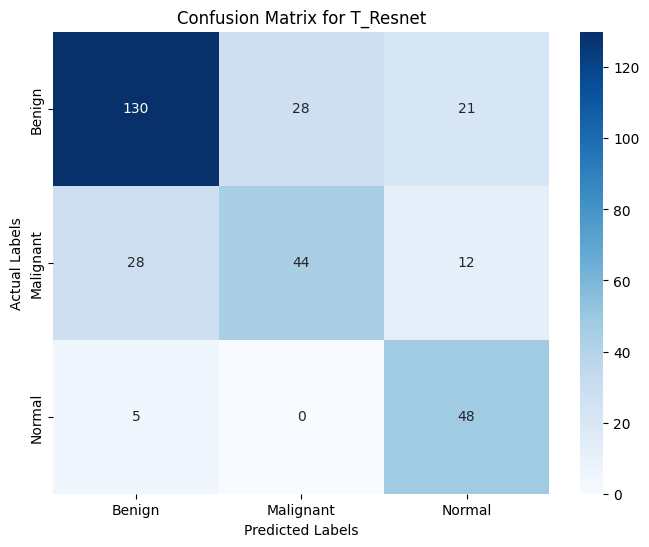

In [50]:
model_name= "T_Resnet"
evaluate_model(model_name,resnet50_model, test_generator)

# Vgg19+transfer

In [25]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

# Optional: For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG19-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained VGG19 model + higher-level layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Binary classification

# Create the complete model
vgg19_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
vgg19_history_initial = vgg19_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
vgg19_history_fine = vgg19_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = vgg19_model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 448ms/step - accuracy: 0.5326 - loss: 3.0884 - val_accuracy: 0.6962 - val_loss: 0.6144
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.6566 - loss: 1.0949 - val_accuracy: 0.7405 - val_loss: 0.4611
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.6878 - loss: 0.8228 - val_accuracy: 0.8544 - val_loss: 0.3948
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.7125 - loss: 0.6798 - val_accuracy: 0.8608 - val_loss: 0.3954
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.7468 - loss: 0.5527 - val_accuracy: 0.7278 - val_loss: 0.4547
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.7001 - loss: 0.6938 - val_accuracy: 0.8291 - val_loss: 0.4074
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.7760 - loss: 0.5131 - val_accuracy: 0.8544 - val_loss: 0.4035
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.7752 - loss: 0.5089 - val_accuracy: 0.8038 - val

In [26]:
vgg19_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 61,059,275 (232.92 MB)

 Trainable params: 20,353,091 (77.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,706,184 (155.28 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
Model: T_VGG19
Accuracy: 0.8544
Precision: 0.8724
Recall: 0.8544
F1 Score: 0.8517
Mean Absolute Error: 0.1930
Root Mean Square Error: 0.5366
AUC Score: 0.9664



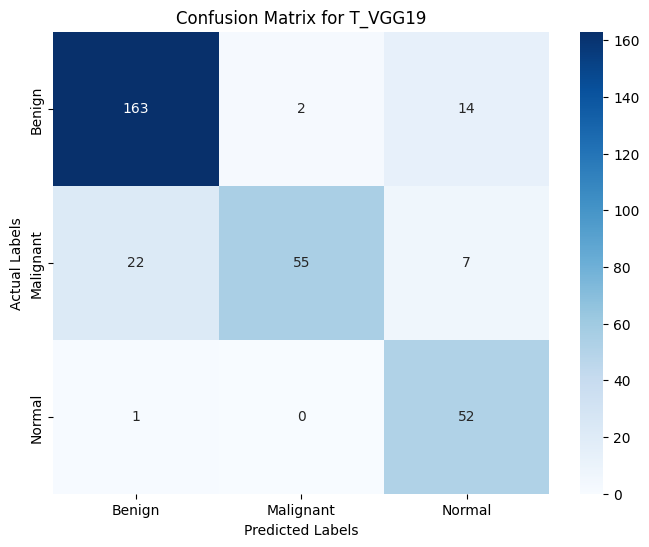

In [27]:
model_name= "T_VGG19"
evaluate_model(model_name,vgg19_model, test_generator) 

# DenseNet121

In [30]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Binary classification output

# Create the complete model
model_densenet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_densenet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_densenet = model_densenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_densenet.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 44s 779ms/step - accuracy: 0.3008 - loss: 1.3085 - val_accuracy: 0.5000 - val_loss: 0.9875
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.4647 - loss: 1.0394 - val_accuracy: 0.5886 - val_loss: 0.8887
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.5693 - loss: 0.9427 - val_accuracy: 0.6392 - val_loss: 0.8179
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.5812 - loss: 0.9506 - val_accuracy: 0.6709 - val_loss: 0.7526
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.6687 - loss: 0.7983 - val_accuracy: 0.6835 - val_loss: 0.7198
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.6621 - loss: 0.8248 - val_accuracy: 0.6962 - val_loss: 0.6814
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.6792 - loss: 0.7518 - val_accuracy: 0.6962 - val_loss: 0.6656
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.6902 - loss: 0.7064 - val_accuracy: 0.6899 - val

In [31]:
model_densenet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 134, 134,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,046,731 (26.88 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 6,152 (24.04 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 916ms/step
Model: Densenet
Accuracy: 0.7722
Precision: 0.8037
Recall: 0.7722
F1 Score: 0.7767
Mean Absolute Error: 0.3165
Root Mean Square Error: 0.7026
AUC Score: 0.9289



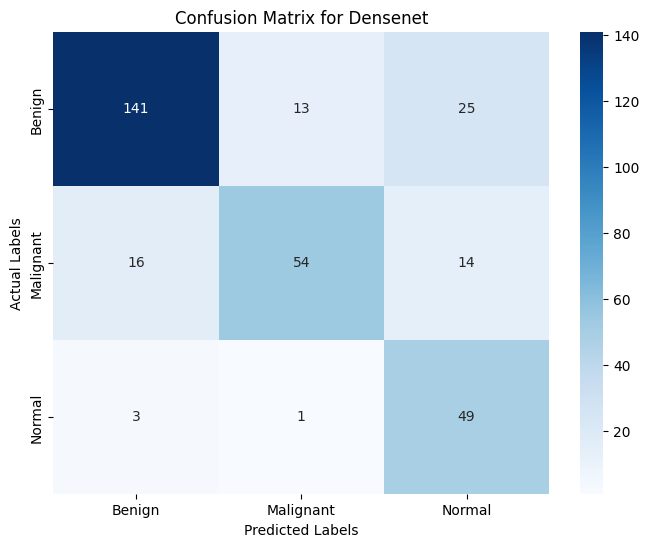

In [32]:
model_name= "Densenet"
evaluate_model(model_name,model_densenet, test_generator)

# Mobilenet

In [33]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained MobileNet model + higher-level layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Binary classification output

# Create the complete model
model_mobilenet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_mobilenet.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.4815 - loss: 1.1690 - val_accuracy: 0.4620 - val_loss: 1.0102
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.5359 - loss: 1.0901 - val_accuracy: 0.5253 - val_loss: 0.8974
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.5864 - loss: 0.9000 - val_accuracy: 0.5506 - val_loss: 0.8291
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.5903 - loss: 0.8591 - val_accuracy: 0.5886 - val_loss: 0.7774
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.6390 - loss: 0.8026 - val_accuracy: 0.6962 - val_loss: 0.7236
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.7178 - loss: 0.7031 - val_accuracy: 0.6899 - val_loss: 0.6993
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.7144 - loss: 0.7040 - val_accuracy: 0.7025 - val_loss: 0.6638
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.7168 - loss: 0.6979 - val_accuracy: 0.7215 - val

In [34]:
model_mobilenet.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,238,091 (12.35 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 6,152 (24.04 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step
Model: Mobilenet
Accuracy: 0.7911
Precision: 0.8129
Recall: 0.7911
F1 Score: 0.7944
Mean Absolute Error: 0.2627
Root Mean Square Error: 0.6085
AUC Score: 0.9340



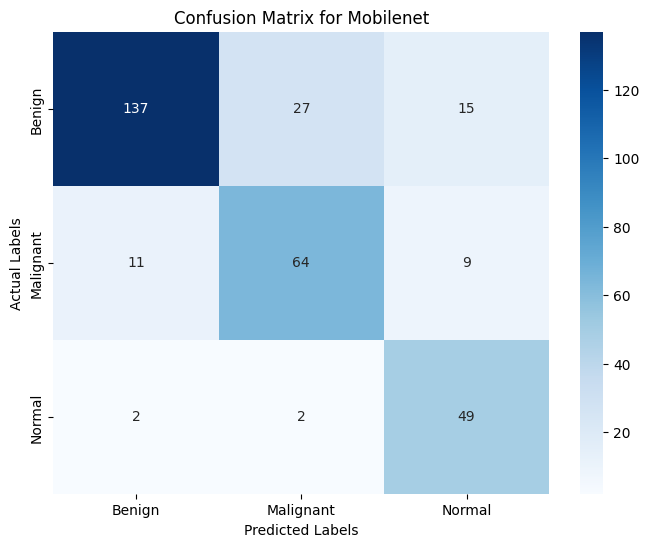

In [35]:
model_name= "Mobilenet"
evaluate_model(model_name,model_mobilenet, test_generator)

# Resnet50

In [46]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained ResNet50 model + higher-level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Binary classification output

# Create the complete model
model_resnet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_resnet = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_resnet.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.5756 - loss: 1.2612 - val_accuracy: 0.5633 - val_loss: 1.0388
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.5797 - loss: 1.1682 - val_accuracy: 0.5633 - val_loss: 1.0303
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.5575 - loss: 1.1525 - val_accuracy: 0.5633 - val_loss: 1.0334
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.5696 - loss: 1.1023 - val_accuracy: 0.5823 - val_loss: 1.0370
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.5416 - loss: 1.1169 - val_accuracy: 0.6139 - val_loss: 1.0408
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.5962 - loss: 1.0662 - val_accuracy: 0.6203 - val_loss: 1.0460
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.5720 - loss: 1.0705 - val_accuracy: 0.5633 - val_loss: 1.0475
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.5314 - loss: 1.0977 - val_accuracy: 0.5443 - val

In [47]:
model_resnet.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,606,155 (90.05 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 12,296 (48.04 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step
Model: Resnet
Accuracy: 0.3291
Precision: 0.7033
Recall: 0.3291
F1 Score: 0.2362
Mean Absolute Error: 0.9367
Root Mean Square Error: 1.2118
AUC Score: 0.7312



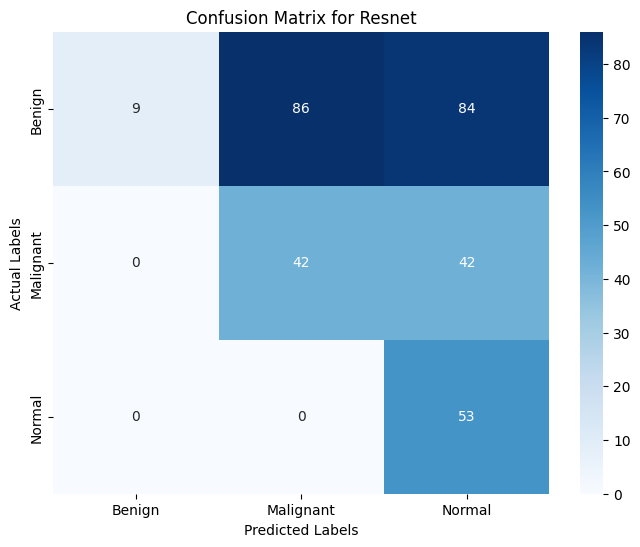

In [48]:
model_name= "Resnet"
evaluate_model(model_name,model_resnet, test_generator)

# Vgg19

In [40]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained VGG19 model + higher-level layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Binary classification output

# Create the complete model
model_vgg = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_vgg = model_vgg.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_vgg.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1104 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 316 images belonging to 3 classes.
Training samples: 1104
Validation samples: 158
Test samples: 316
Class Weights: {0: 0.5906902086677368, 1: 1.2474576271186442, 2: 1.978494623655914}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.1625 - loss: 1.0946 - val_accuracy: 0.3608 - val_loss: 1.0674
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.3174 - loss: 1.0986 - val_accuracy: 0.6329 - val_loss: 1.0346
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.5267 - loss: 1.0925 - val_accuracy: 0.6582 - val_loss: 1.0163
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.5718 - loss: 1.0540 - val_accuracy: 0.6772 - val_loss: 1.0013
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.5824 - loss: 1.0281 - val_accuracy: 0.7722 - val_loss: 0.9903
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.6398 - loss: 1.0308 - val_accuracy: 0.7595 - val_loss: 0.9807
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6638 - loss: 1.0156 - val_accuracy: 0.7468 - val_loss: 0.9750
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.6418 - loss: 1.0208 - val_accuracy: 0.7595 - val

In [41]:
model_vgg.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 20,029,003 (76.40 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 3,080 (12.04 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
Model: VGG19
Accuracy: 0.7184
Precision: 0.7575
Recall: 0.7184
F1 Score: 0.7254
Mean Absolute Error: 0.3987
Root Mean Square Error: 0.7956
AUC Score: 0.8917



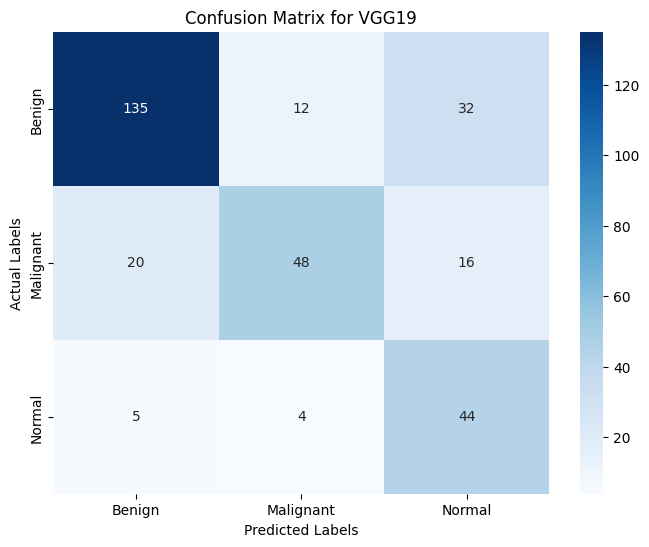

In [42]:
model_name= "VGG19"
evaluate_model(model_name,model_vgg, test_generator)

# Evaluation Curves

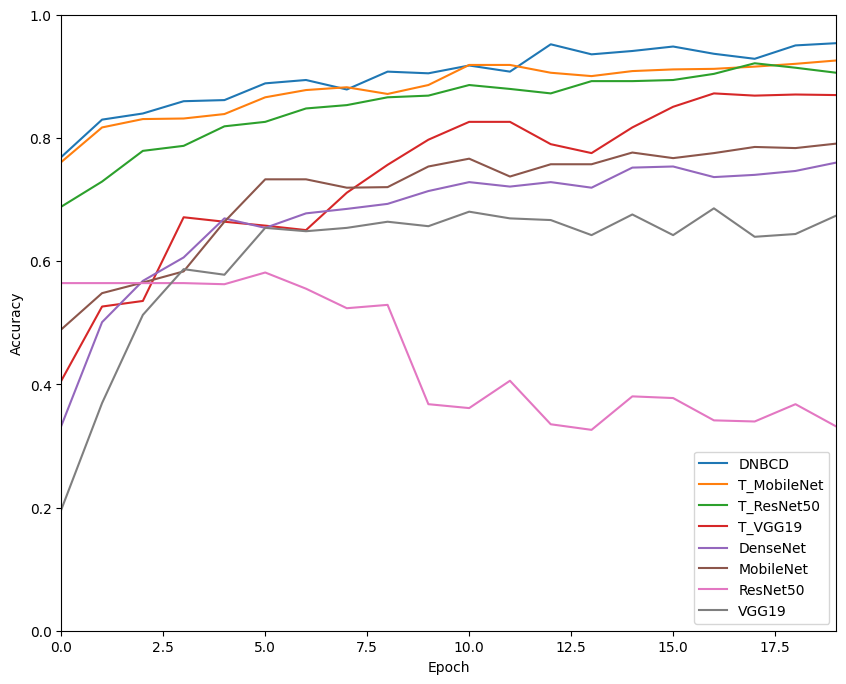

In [54]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['accuracy']
acc_tmobilenet = mobilenet_history_fine.history['accuracy']
acc_tresnet50 = resnet50_history_fine.history['accuracy']
acc_tvgg19 = vgg19_history_fine.history['accuracy']
acc_densenet = history_densenet.history['accuracy']
acc_mobilenet = history_mobilenet.history['accuracy']
acc_resnet50 = history_resnet.history['accuracy']
acc_vgg19 = history_vgg.history['accuracy']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Set legend in bottom-right corner
plt.legend(loc='lower right')
plt.ylim(0, 1)
# Remove gap from the y-axis
plt.gca().margins(x=0)

beingsaved.savefig('Accuracy.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


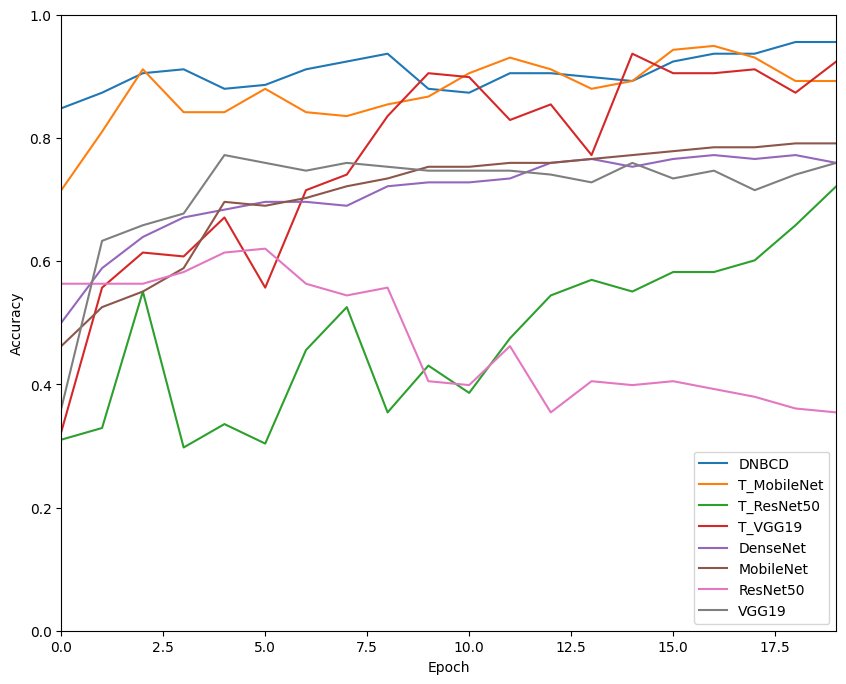

In [55]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['val_accuracy']
acc_tmobilenet = mobilenet_history_fine.history['val_accuracy']
acc_tresnet50 = resnet50_history_fine.history['val_accuracy']
acc_tvgg19 = vgg19_history_fine.history['val_accuracy']
acc_densenet = history_densenet.history['val_accuracy']
acc_mobilenet = history_mobilenet.history['val_accuracy']
acc_resnet50 = history_resnet.history['val_accuracy']
acc_vgg19 = history_vgg.history['val_accuracy']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Set legend in bottom-right corner
plt.legend(loc='lower right')
plt.ylim(0, 1)
# Remove gap from the x-axis
plt.gca().margins(x=0)

beingsaved.savefig('Val_Accuracy.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


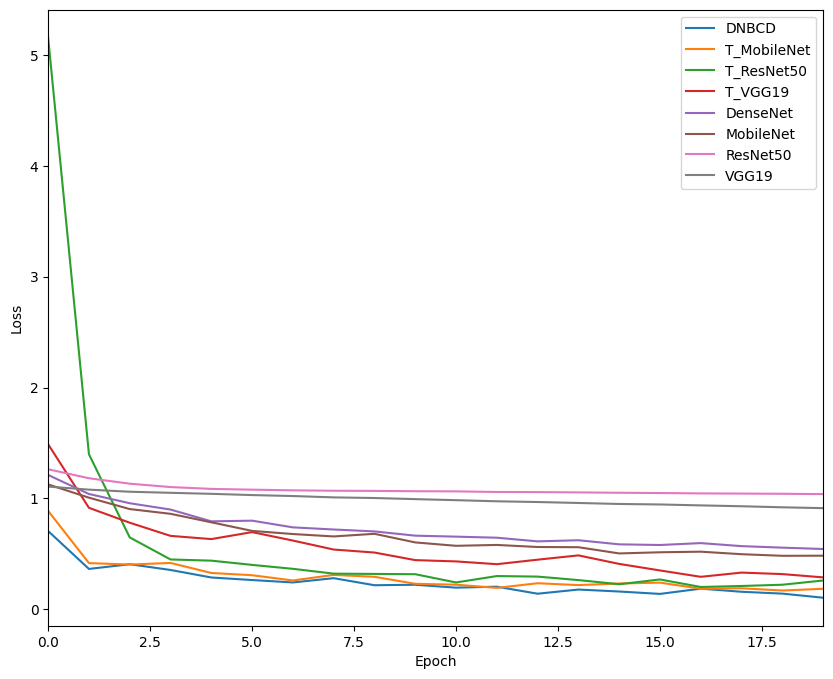

In [56]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['loss']
acc_tmobilenet = mobilenet_history_fine.history['loss']
acc_tresnet50 = resnet50_history_fine.history['loss']
acc_tvgg19 = vgg19_history_fine.history['loss']
acc_densenet = history_densenet.history['loss']
acc_mobilenet = history_mobilenet.history['loss']
acc_resnet50 = history_resnet.history['loss']
acc_vgg19 = history_vgg.history['loss']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Remove gap from the y-axis
plt.gca().margins(x=0)

beingsaved.savefig('Loss.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


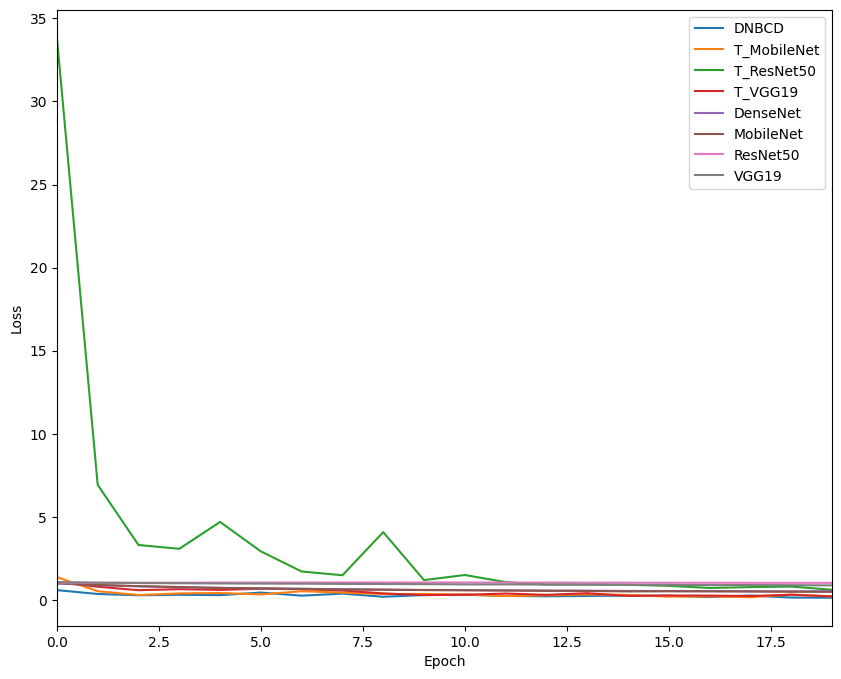

In [57]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['val_loss']
acc_tmobilenet = mobilenet_history_fine.history['val_loss']
acc_tresnet50 = resnet50_history_fine.history['val_loss']
acc_tvgg19 = vgg19_history_fine.history['val_loss']
acc_densenet = history_densenet.history['val_loss']
acc_mobilenet = history_mobilenet.history['val_loss']
acc_resnet50 = history_resnet.history['val_loss']
acc_vgg19 = history_vgg.history['val_loss']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Remove gap from the y-axis
plt.gca().margins(x=0)

beingsaved.savefig('Val_Loss.png', format='png', dpi=600, bbox_inches="tight")
plt.show()
